# NN Model Propeller - Pure data-driven

Additional time varying part in the model

In [1]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torchviz import make_dot
from scipy.fftpack import fft, ifft

# Physics
from ccblade import CCBlade, CCAirfoil
import logging
from typing import Tuple

# Plotting
import matplotlib.pyplot as plt

In [164]:
import datetime
date = datetime.date.today()

## Physics Functions (CCBlade)

In [165]:
# Configure logging
logging.basicConfig(level=logging.INFO)

# Initialization of perating condition
DEFAULT_RHO = 1.225  # Air density in kg/m^3
DEFAULT_RE = 1e6  # Reynolds number
DEFAULT_J = 0.125  # Advance ratio
DEFAULT_OMEGA = 2000  # Rotational speed in RPM

DEFAULT_PITCH = 0.0
DEFAULT_TILT = 0.0
DEFAULT_YAW = 0.0

# -----------------------------------------------------------------
# Utility functions
# -----------------------------------------------------------------

def find_path(data_path: str, target_file: str) -> str:
    """
    Recursively search for the file in the directory and return the path.

    Parameters:
    data_path (str): The root directory to start the search.
    target_file (str): The file to search for.

    Returns:
    str: Full path to the target file.
    """
    for dirpath, _, filenames in os.walk(data_path):
        if target_file in filenames:
            target_file_path = os.path.join(dirpath, target_file)
            return target_file_path
    logging.error(f"File '{target_file}' not found in '{data_path}'.")
    raise FileNotFoundError(f"File '{target_file}' not found.")

def calculate_coefficients(Thrust: float, Torque: float, rho: float, Rtip: float, Omega: float, precone: float = 0.0) -> Tuple[float, float]:
    """
    Calculate the thrust coefficient (CT) and torque coefficient (CQ).

    Parameters:
    Thrust (float): Thrust in Newtons (N)
    Torque (float): Torque in Newton-meters (Nm)
    rho (float): Air density in kg/m^3
    Rtip (float): Blade tip radius in meters.
    Omega (float): Rotational speed in RPM
    precone (float, optional): Blade precone angle in degrees. Default is 0.0.

    Returns:
    Tuple[float, float]: Thrust coefficient (CT) and torque coefficient (CQ)
    """
    if Rtip <= 0 or Omega <= 0 or rho <= 0:
        raise ValueError("Rtip, Omega, and rho must be positive.")

    n = Omega / 60  # Convert RPM to RPS
    D = 2 * Rtip * np.cos(np.radians(precone))  # Rotor diameter

    thrust_coefficient = Thrust / (rho * n**2 * D**4)
    torque_coefficient = Torque / (rho * n**2 * D**5)

    logging.info(f"Calculated Coefficients - CT: {thrust_coefficient}, CQ: {torque_coefficient}")
    return thrust_coefficient, torque_coefficient

# -----------------------------------------------------------------
# Main rotor analysis function
# -----------------------------------------------------------------

def analyze_rotor(data_path: str, rotor_file: str, Omega: float = DEFAULT_OMEGA, J: float = DEFAULT_J, rho: float = DEFAULT_RHO, Re = DEFAULT_RE,
                  pitch: float = DEFAULT_PITCH, tilt: float = DEFAULT_TILT, yaw: float = DEFAULT_YAW):
    """
    Analyzes the rotor using data from the database, computes the thrust and torque coefficients.

    Parameters:
    data_path (str): Path to the rotor database.
    rotor_file (str): Name of the rotor configuration file.
    Omega (float, optional): Rotational velocity in RPM. Default is 9200.
    J (float, optional): Advance ratio. Default is 0.7.
    rho (float, optional): Air density in kg/m^3. Default is 1.225.
    
    Returns:
    Tuple[float, float]: Thrust coefficient (CT) and torque coefficient (CQ)
    """
    try:
        rotor_file_path = find_path(data_path, rotor_file)
        rotor_data = pd.read_csv(rotor_file_path)

        Rtip = float(rotor_data["file"].values[0])  # Tip radius
        Rhub = float(rotor_data["file"].values[1])  # Hub radius
        n_blades = float(rotor_data["file"].values[2])  # Number of blades
        
        # Rest of the data processing (blade geometry, chord, pitch, etc.)
        blade_file = rotor_data["file"].values[3]
        blade_file_path = find_path(data_path, blade_file)
        blade_data = pd.read_csv(blade_file_path)
        
        # List of blade geometry files
        chord_file = blade_data["file"].values[0]               # rotor_chorddist.csv
        pitch_file = blade_data["file"].values[1]               # rotor_pitchdist.csv
        sweep_file = blade_data["file"].values[2]               # rotor_sweepdist.csv
        height_file = blade_data["file"].values[3]              # rotor_heightdist.csv
        airfoil_files = blade_data["file"].values[4]            


        # Airfoil sections
        airfoil_file_path = find_path(data_path, airfoil_files)
        airfoil_section_data = pd.read_csv(airfoil_file_path)

        # Propeller cross-section radius
        r_nondim = airfoil_section_data["r/R"].values

        # Dimensionalized R
        r = Rtip * r_nondim                                                 # Radial distance of blade cross-sections in m

        # airfoil_sections = airfoil_section_data["Contour file"].values

        # Chord
        chord_file_path = find_path(data_path, chord_file)
        chord_data = pd.read_csv(chord_file_path)

        chord_r = chord_data["r/R"].values
        chord_c = chord_data["c/R"].values

        # Dimensionalized chord 
        c = Rtip * np.interp(r_nondim, chord_r, chord_c)                    # Chord, c at cross-section r in m

        # Pitch
        pitch_file_path = find_path(data_path, pitch_file)
        pitch_data = pd.read_csv(pitch_file_path)

        pitch_r = pitch_data["r/R"].values
        pitch_the = pitch_data["twist (deg)"].values

        # Blade pitch angle
        theta = np.interp(r_nondim, pitch_r, pitch_the)                     # Pitch angle of the blade at cross-section r in degrees

        # Blade Sweep
        sweep_file_path = find_path(data_path, sweep_file)
        sweep_data = pd.read_csv(sweep_file_path)
        sweep_r = sweep_data["r/R"].values
        sweep_y = sweep_data["y/R (y-distance of LE from the middle point of hub)"].values

        y = Rtip * np.interp(r_nondim, sweep_r, sweep_y)
        sweep_tip = Rtip * sweep_y[-1]

        # Blade height
        height_file_path = find_path(data_path, height_file)
        height_data = pd.read_csv(height_file_path)
        height_r = height_data["r/R"].values
        height_z = height_data["z/R  (height of leading edge from top face of hub)"].values

        z = Rtip * np.interp(r_nondim, height_r, height_z)
        height_tip = Rtip * height_z[-1]

        contour_files = airfoil_section_data["Contour file"].values
        polar_files = airfoil_section_data["Aero file"].values

        airfoil_type = [None]*len(contour_files)
        for i, airfoil in enumerate(contour_files):
            polar_file = polar_files[i]
            polar_file_path = find_path(data_path, polar_file)
            polar_file_data = pd.read_csv(polar_file_path)
            AoAs = polar_file_data["Alpha"].values
            Cl = polar_file_data["Cl"].values
            Cd = polar_file_data["Cd"].values
            Cm = polar_file_data["Cm"].values

            airfoil_type[i] = CCAirfoil(AoAs, [Re], Cl, Cd)

        Uinf = J * Omega / 60 * (2 * Rtip)  # Free stream velocity [m/s]
        
        rotor = CCBlade(r=r, chord=c, theta=theta, af=airfoil_type, Rhub=Rhub, Rtip=Rtip,
                        B=n_blades, rho=rho, precone=0, tilt=tilt, yaw=yaw, precurve=z, precurveTip=height_tip,
                        presweep=y, presweepTip=sweep_tip, tiploss=True, hubloss=True)

        eval_results = rotor.evaluate([Uinf], [Omega], [pitch])
        P = eval_results[0]["P"]
        T = -eval_results[0]["T"]
        Q = -eval_results[0]["Q"]

        logging.info(f"Torque: {Q}, Thrust: {T}")

        CT, CQ = calculate_coefficients(T, Q, rho, Rtip, Omega)
        return CT, CQ

    except Exception as e:
        logging.error(f"An error occurred: {e}")
        raise e

## Dataset class

In [166]:
       
# Condition function to filter subdirectories
def subdir_condition(subdir_name):
    """
    Condition: Only process subdirectories whose names start with 'propeller-example_dji'.
    Modify this function to apply a specific filtering logic.
    """
    return subdir_name.startswith('dataset')  # Change this condition as needed


class PropellerDataset(Dataset):
    # def __init__(self, root_dir, alpha, J, theta, yaw, tilt, subdir_condition=None):
    def __init__(self, root_dir, subdir_condition=None):
        """
        Args:
            root_dir (string): Root directory with subdirectories containing CSV files.
            alpha (float): Angle of attack.
            J (float): Advance ratio.
            theta (float): Pitch.
            yaw (float): Yaw.
            tilt (float): Tilt.
            subdir_condition (callable, optional): A function or condition to filter subdirectories by name.
        """
        self.root_dir = root_dir
        # self.alpha = alpha
        # self.J = J
        # self.theta = theta
        # self.yaw = yaw
        # self.tilt = tilt
        self.data = []
        self.targets = []
        self.time_data = []  # Store time data separately
        self.omega_data = []  # Store omega (RPM) separately
        self.ref_angle_data = []
        self.tilt_data = []
        self.pitch_data = []
        self.yaw_data = []
        self.J_data = []
        self.ct_data = []
        self.cq_data = []
        self.fft_ct_r = []
        self.fft_ct_i = []
        self.fft_cq_r = []
        self.fft_cq_i = []
        self.subdir_condition = subdir_condition

        # Traverse the root directory to gather data
        self._load_data()

    def _load_data(self):
        """
        Helper function to read CSV files from each subdirectory and extract relevant columns.
        """
        # Iterate through each subdirectory in the root directory
        for subdir, _, files in os.walk(self.root_dir):
            subdir_name = os.path.basename(subdir)
            
            # Apply subdirectory name condition
            if self.subdir_condition and not self.subdir_condition(subdir_name):
                continue

            for file in files:
                if file.endswith("_convergence.csv"):
                    # Load the CSV file
                    csv_path = os.path.join(subdir, file)
                    df = pd.read_csv(csv_path)
                    
                    # Extract necessary columns for input features
                    time = df['T'].values  # Time
                    omega = df['RPM_1'].values  # RPM
                    J = df['J'].values
                    AOA = df['AOA'].values
                    pitch = df['Pitch (blade)'].values
                    tilt = df['Tilt'].values
                    yaw = df['Yaw'].values
                    ref_angle = df['ref age (deg)'].values

                    # Extract CT and CQ as output variables
                    ct = df['CT_1'].values  # Thrust coefficient (CT)
                    cq = df['CQ_1'].values  # Torque coefficient (CQ)

                    # Perform Fourier transformation to separate real and imaginary part
                    fft_ct = fft(ct)
                    fft_ct_real = np.real(fft_ct)
                    fft_ct_imag = np.imag(fft_ct)

                    fft_cq = fft(cq)
                    fft_cq_real = np.real(fft_cq)
                    fft_cq_imag = np.imag(fft_cq)


                    # Store time and omega in separate lists for easy access
                    self.time_data.append(time)
                    self.omega_data.append(omega)
                    self.J_data.append(J)
                    self.ref_angle_data.append(ref_angle)
                    self.pitch_data.append(pitch)
                    self.tilt_data.append(tilt)
                    self.yaw_data.append(yaw)
                    
                                   
                    # Store ct and cq in separate lists for easy access
                    self.ct_data.append(ct)
                    self.cq_data.append(cq)
                    self.fft_ct_r.append(fft_ct_real)
                    self.fft_ct_i.append(fft_ct_imag)
                    self.fft_cq_r.append(fft_cq_real)
                    self.fft_cq_i.append(fft_cq_imag)

                    # For each simulation, the input sequence is structured as (n_timesteps, n_features)
                    sequence_inputs = []
                    sequence_outputs = []
                    for i in range(len(time)):
                        # Each time step has time, omega, and predefined variables: alpha, J, theta, yaw, tilt
                        input_data = [
                            time[i], ref_angle[i], omega[i], (100*np.sin(omega[i]*time[i])), 
                            (100*np.cos(omega[i]*time[i])), AOA[i], J[i], pitch[i], tilt[i], yaw[i]
                            # omega[i], AOA[i], J[i], pitch[i], tilt[i], yaw[i]
                        ]
                        # output_data = [ct[i], cq[i], fft_ct_imag[i], fft_cq_imag[i]]
                        output_data = [fft_ct_real[i], fft_ct_imag[i], fft_cq_real[i], fft_cq_imag[i]]
                        
                        
                        sequence_inputs.append(input_data)
                        sequence_outputs.append(output_data)

                    sequence_inputs = np.array([sequence_inputs], dtype=float)
                    sequence_outputs = np.array([sequence_outputs], dtype=float)

                    # Append input sequence (n_timesteps, num_features) and output (CT, CQ)
                    self.data.append(sequence_inputs)
                    self.targets.append(sequence_outputs)  # Append the whole CT and CQ sequences


    def __len__(self):
        """
        Returns the total number of sequences in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single sequence and its targets.
        """
        inputs = self.data[idx]  # Input sequence: (n_timesteps, n_features)
        targets = self.targets[idx]  # Output: (n_timesteps, 2)
        # return inputs, targets
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

    def get_variable(self, variable_name):
        """
        Returns a list of arrays for the specified variable.
        Args:
            'time' - timesteps
            'omega' - rotational velocity [RPM]
            'CT' - Thrust coefficient
            'CQ' - Torque coefficient
            'J' - Advance ratio
            'ref_angle' - Rotor rotation angle [degrees]
            'tilt', 'yaw' - Rotor orientation [degrees]
            'blade_pitch' - Rotor blade collective pitch [degrees]
            'fft_ct_r' - Thrust ccoefficient FFT - real part
            'fft_ct_i' - Thrust ccoefficient FFT - imag part
            'fft_cq_r' - Torque ccoefficient FFT - real part
            'fft_cq_i' - Torque ccoefficient FFT - imag part
             

        """
        if variable_name == 'time':
            return self.time_data  # Return all time steps for each simulation
        elif variable_name == 'omega':
            return self.omega_data  # Return all omega (RPM) values for each simulation
        elif variable_name == 'CT':
            return self.ct_data 
        elif variable_name == 'CQ':
            return self.cq_data
        elif variable_name == 'J':
            return self.J_data
        elif variable_name == 'ref_angle':
            return self.ref_angle_data
        elif variable_name == 'tilt':
            return self.tilt_data
        elif variable_name == 'yaw':
            return self.yaw_data
        elif variable_name == 'blade_pitch':
            return self.pitch_data
        elif variable_name == 'fft_ct':
            return self.fft_ct_r, self.fft_ct_i 
        elif variable_name == 'fft_cq':
            return self.fft_cq_r, self.fft_cq_i  
        else:
            raise ValueError(f"Variable {variable_name} not supported.")



In [167]:
# Define the custom dataset class
# Creates training and validation datasets
class SimulationDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.outputs[idx], dtype=torch.float32)

## Extract and organize data

In [168]:
def visualize_tabular_dataset(inputs, targets, visualize:bool):
    
    if visualize:
        # Additional part to visualize the data
        df_ips = [None]*len(inputs)
        df_ops = [None]*len(targets)

        for num_batch in range(len(inputs)):
            df_ips[num_batch] = pd.DataFrame(inputs[num_batch], columns=["timestep", "sin_comp", "cos_comp", "Omega", "alpha", "J", "theta", "tilt", "yaw"])
            # df_ops[num_batch] = pd.DataFrame(targets[num_batch], columns=["CT", "CQ", "fft_ct_imag", "fft_cq_imag"])
            df_ops[num_batch] = pd.DataFrame(targets[num_batch], columns=["fft_ct_real", "fft_ct_imag", "fft_cq_real", "fft_cq_imag"])

        print("Input dataset\n", df_ips)
        print("Target dataset\n", df_ops)

In [169]:
# Parameters to define
alpha = 0.0   # Angle of attack
J = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]       # Advance ratio
theta = 0.0  # Pitch
yaw = 0.0     # Yaw
tilt = 0.0    # Tilt

# Root directory where simulation subdirectories are stored
root_dir = "./FLOWUnsteady_simulations/train_data/"

visualize_dataset = True        # Visualize loaded dataset
visualize_norm_dataset = False   # Visualize normalized dataset
visualize_nn = True              # Visulaize NN structure

In [170]:
# Create the dataset with a subdirectory condition
# dataset = PropellerDataset(root_dir, alpha, J, theta, yaw, tilt, subdir_condition=subdir_condition)
dataset = PropellerDataset(root_dir, subdir_condition=subdir_condition)
inputs, outputs = dataset[0:]


input_tensor = inputs.squeeze(1)  # Reshaping
print("Input shape:", input_tensor.shape)  # Should print: torch.Size([6, 145, 7])

output_tensor = outputs.squeeze(1)
print("Output shape:",output_tensor.shape)  # Should print: torch.Size([6, 145, 2])


Input shape: torch.Size([42, 181, 10])
Output shape: torch.Size([42, 181, 4])


## NN Model

In [171]:
# LSTM Model Definition
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out)
        return out
    

In [172]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Train the model

### Define Hyperparameters

In [176]:
# Hyperparameters
input_size = 10  # Number of input features (e.g., 7 input variables)
hidden_size = 50  # Number of LSTM units (hidden state size)
output_size = 4  # Number of output features (e.g., 2 for thrust and torque coefficients)
num_layers = 2  # Number of LSTM layers
learning_rate = 0.005
num_epochs = 15
batch_size = 5

### Normalize the dataset

In [180]:
# Initialize scalers for input and output
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

# Reshape data for scaling (flatten along the time dimension)
inputs_reshaped = input_tensor.reshape(-1, input_size)
outputs_reshaped = output_tensor.reshape(-1, output_size)

# Fit and transform inputs and outputs
inputs_normalized = input_scaler.fit_transform(inputs_reshaped).reshape(input_tensor.shape)
outputs_normalized = output_scaler.fit_transform(outputs_reshaped).reshape(output_tensor.shape)

print("Normalized input shape:", inputs_normalized.shape)
print("Normalized output shape:", outputs_normalized.shape)

# View dataset in tabular form - change visualize to True
visualize_tabular_dataset(inputs_normalized, outputs_normalized, visualize=visualize_norm_dataset)

Normalized input shape: (42, 181, 10)
Normalized output shape: (42, 181, 4)


### Split the dataset

In [175]:
test_percentage = 0.35
train_dataset_num = len(dataset) - int(len(dataset)*test_percentage)
print("Number of datasets to be used for training:", train_dataset_num)
print("Number of datasets to be used for evaluation:", len(dataset) - train_dataset_num)

# Create the normalized dataset using the custom Dataset class
train_dataset = SimulationDataset(inputs_normalized[:train_dataset_num], outputs_normalized[:train_dataset_num])  # First 4 for training
val_dataset = SimulationDataset(inputs_normalized[train_dataset_num:], outputs_normalized[train_dataset_num:])   # Remaining for evaluation

# Create DataLoaders
trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valDataLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


Number of datasets to be used for training: 28
Number of datasets to be used for evaluation: 14


## CCBlade

/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/ccblade/ccblade.py:998: UserWarning: error.  check input values.
  warnings.warn("error.  check input values.")
INFO:root:Torque: [-0.19488499], Thrust: [-12.68684414]
INFO:root:Calculated Coefficients - CT: [-0.10754771], CQ: [-0.00688359]
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/ccblade/ccblade.py:998: UserWarning: error.  check input values.
  warnings.warn("error.  check input values.")
INFO:root:Torque: [-0.19488499], Thrust: [-12.68684414]
INFO:root:Calculated Coefficients - CT: [-0.10754771], CQ: [-0.00688359]
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/ccblade/ccblade.py:998: UserWarning: error.  check input values.
  warnings.warn("error.  check input values.")
INFO:root:Torque: [-0.19488499], Thrust: [-12.68684414]
INFO:root:Calculated Coefficients - CT: [-0.10754771], CQ: [-0.00688359]
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/li

Text(0, 0.5, 'Torque coefficient, $C_q$')

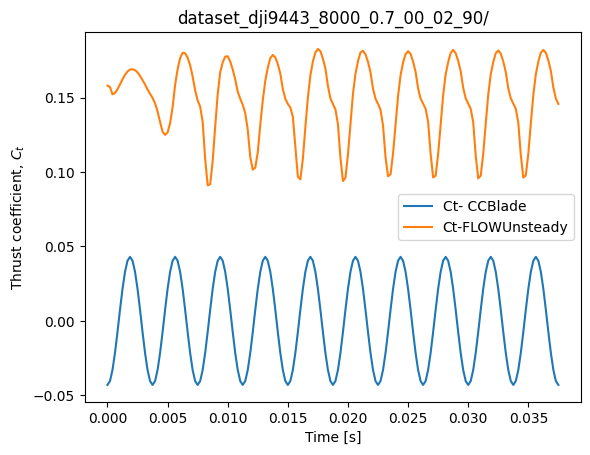

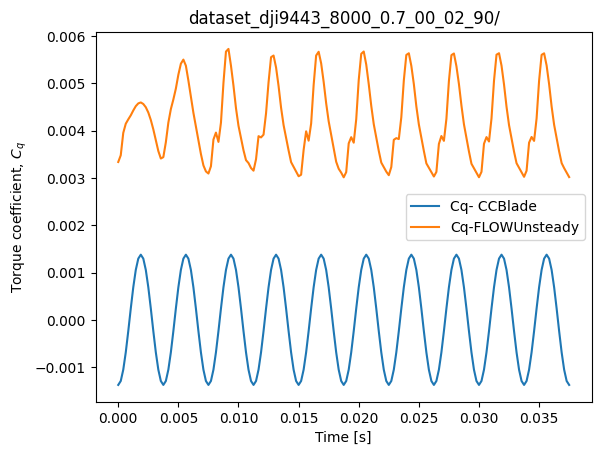

In [147]:
# FlowUnsteady database
rotor_file = 'DJI9443.csv'
data_path = 'rotor_database/'

# Operating conditions
rho_air = 1.225  # Air density in kg/m^3
Re = 1e6  # Reynolds number

flowuns_filepath = "./FLOWUnsteady_simulations/train_data/"
flowuns_filename = "dataset_dji9443_8000_0.7_00_02_90/"

root_sim_data = flowuns_filepath+flowuns_filename

rotor_data_file = [f for f in os.listdir(root_sim_data) if f.endswith ('_convergence.csv')]

rotor_sim_data = pd.read_csv(root_sim_data+rotor_data_file[0])

time = rotor_sim_data["T"].values
Omega = rotor_sim_data["RPM_1"].values
J = rotor_sim_data["J"].values
pitch = rotor_sim_data['Pitch (blade)'].values
tilt = rotor_sim_data['Tilt'].values
yaw = rotor_sim_data['Yaw'].values
ref_angle = rotor_sim_data['ref age (deg)'].values

CT_flowuns = rotor_sim_data["CT_1"].values
CQ_flowuns = rotor_sim_data["CQ_1"].values

CT_ccb = []
CQ_ccb = []
output_CCB = []

for iter in range(0, len(time)):
    Omega_iter = Omega[iter]

    ct, cq = analyze_rotor(data_path, rotor_file, Omega_iter, J[iter], pitch[iter], tilt[iter], yaw[iter])

    ct = ct *0.4* np.cos((ref_angle[iter]) * 2 * np.pi /180)
    cq = cq *0.2* np.cos((ref_angle[iter]) * 2 * np.pi /180)

    CT_ccb.append(ct)
    CQ_ccb.append(cq) 
    output_CCB.append([ct, cq])

output_CCB = np.array(output_CCB)
# print(output_CCB)

plt.figure()
plt.plot(time, CT_ccb, label="Ct- CCBlade")
plt.plot(time, CT_flowuns, label="Ct-FLOWUnsteady")
plt.legend()
plt.title(flowuns_filename)
plt.xlabel('Time [s]')
plt.ylabel('Thrust coefficient, $C_t$')

plt.figure()
plt.plot(time, CQ_ccb, label="Cq- CCBlade")
plt.plot(time, CQ_flowuns, label="Cq-FLOWUnsteady")
plt.legend()
plt.title(flowuns_filename)
plt.xlabel('Time [s]')
plt.ylabel('Torque coefficient, $C_q$')

# plt.show()

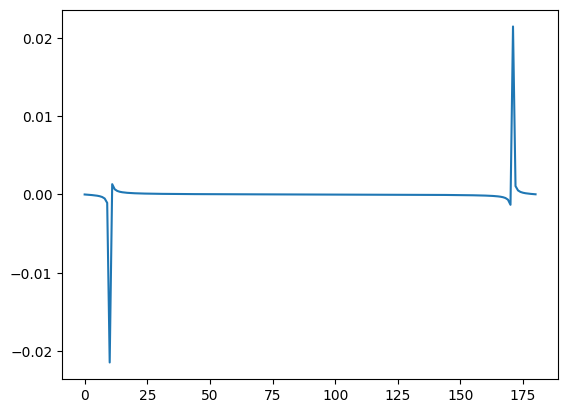

In [162]:
CT_ccb = np.array(CT_ccb).reshape(1, -1)
CQ_ccb = np.array(CQ_ccb).reshape(1, -1)

fft_CT_ccb = fft(CT_ccb)
fft_CT_ccb_real = np.real(fft_CT_ccb)
fft_CT_ccb_imag = np.imag(fft_CT_ccb)

fft_CQ_ccb = fft(CQ_ccb)
fft_CQ_ccb_real = np.real(fft_CQ_ccb)
fft_CQ_ccb_imag = np.imag(fft_CQ_ccb)

# print(fft_CT_ccb_real)
plt.plot(fft_CQ_ccb_imag[0])


# output_CCB = output_CCB.reshape(1, -1, 2)
# print(output_CCB.shape)

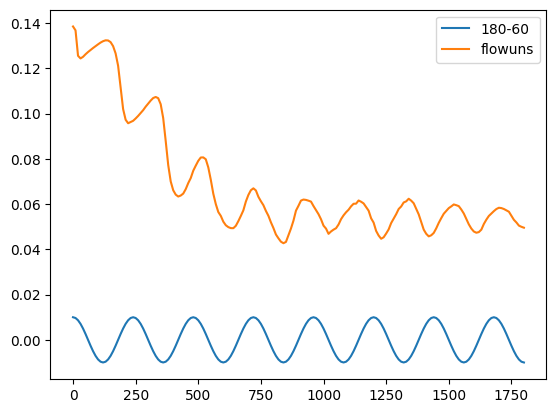

In [143]:
ref_ang = dataset.get_variable('ref_angle')
ct = dataset.get_variable('CT')

ct_CCB = np.array(ct[1])
ref_ang_CCB = np.array(ref_ang[1])

# plt.plot(ref_ang_CCB, 0.01*np.cos(ref_ang_CCB * np.pi /180), label='180')
plt.plot(ref_ang_CCB, 0.01*np.cos((ref_ang_CCB) *1.5* np.pi /180), label='180-60')
plt.plot(ref_ang_CCB, ct_CCB, label='flowuns')
plt.legend()


### Training ...

In [177]:

# Instantiate model, loss function, and optimizer
model = LSTMNet(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
eval_losses = []

print("[INFO] training the network...")

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in trainDataLoader:

        print(inputs.shape)
        print(targets.shape)
        inputs, targets = inputs.squeeze(1).to(device), targets.squeeze(1).to(device)

        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainDataLoader)
    train_losses.append(avg_train_loss)


    # Evaluation Loop
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for inputs, targets in valDataLoader:
            inputs, targets = inputs.squeeze(1).to(device), targets.squeeze(1).to(device)
            
            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(valDataLoader)
        eval_losses.append(avg_eval_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}],\n Training Loss: {running_loss/len(trainDataLoader):.4f}')
    print(f'Evaluation Loss: {eval_loss/len(valDataLoader):.4f}')

print("\nFinished Training...")

[INFO] training the network...
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([3, 181, 10])
torch.Size([3, 181, 4])
Epoch [1/15],
 Training Loss: 0.0559
Evaluation Loss: 0.0146
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([3, 181, 10])
torch.Size([3, 181, 4])
Epoch [2/15],
 Training Loss: 0.0083
Evaluation Loss: 0.0053
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([5, 181, 10])
torch.Size([5, 181, 4])
torch.Size([3,

### Plot the losses

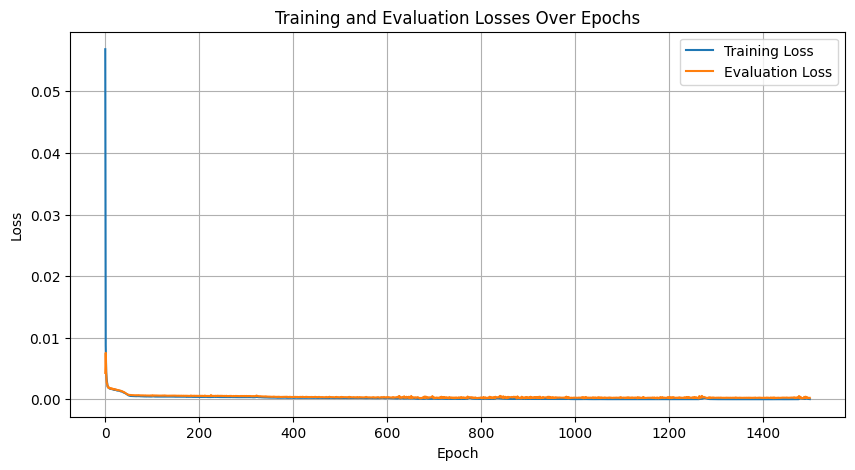

In [103]:
# Plotting the training and evaluation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Visualize NN structure

In [ ]:
# Create a dummy input tensor (batch_size, elements)
# Assuming 170 elements, batch_size = 1
dummy_input = torch.randn(1, 10, 7).to(device)

# Pass the dummy input through the model
dummy_output = model(dummy_input)

# Generate the computational graph
dot = make_dot(dummy_output, params=dict(model.named_parameters()))

# Display the graph
dot

In [ ]:
# Save the model if needed
save_path =  './Trained_models/{}_propModel_lr{}_e{}_nL{}_numNN{}.pth'.format(date, learning_rate, num_epochs, num_layers, hidden_size)
print("The model will be saved as the following:\n {}".format(save_path))


torch.save(model.state_dict(), save_path)

## Test the model

Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 4])


/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 4])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 4])


/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 4])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 4])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 4])


/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 4])


/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/f/Course_Materials/ROM/rotor_solver/rotor/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


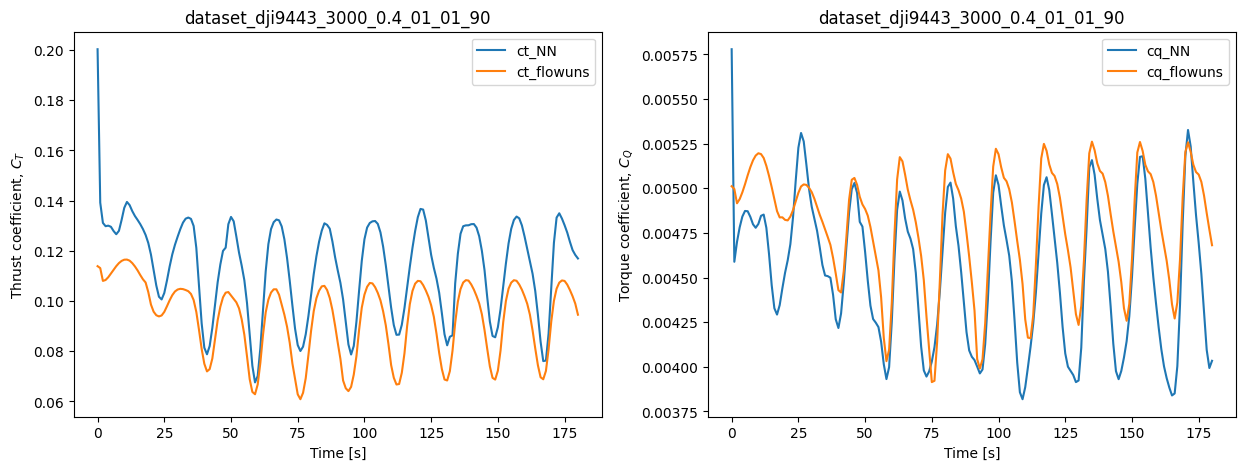

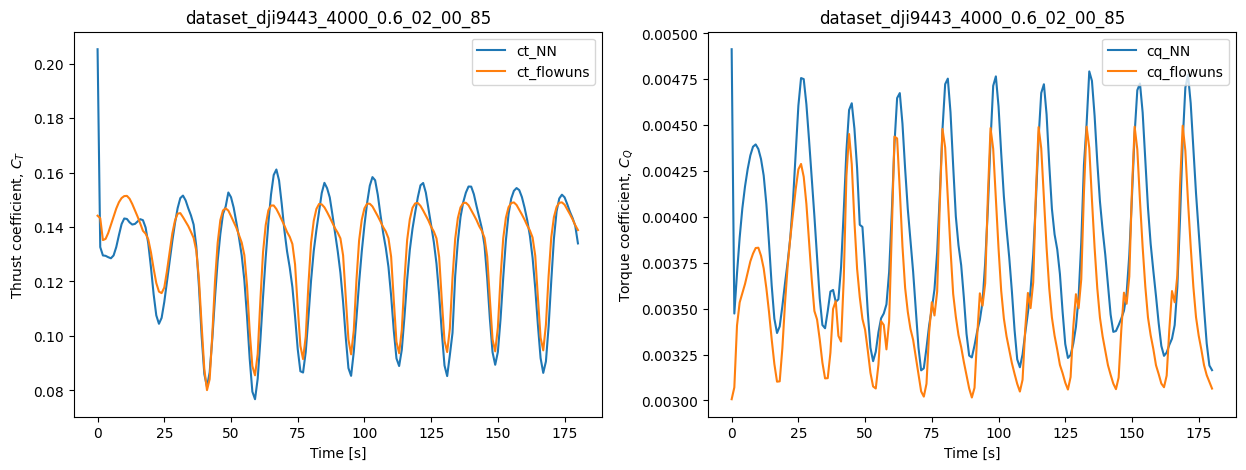

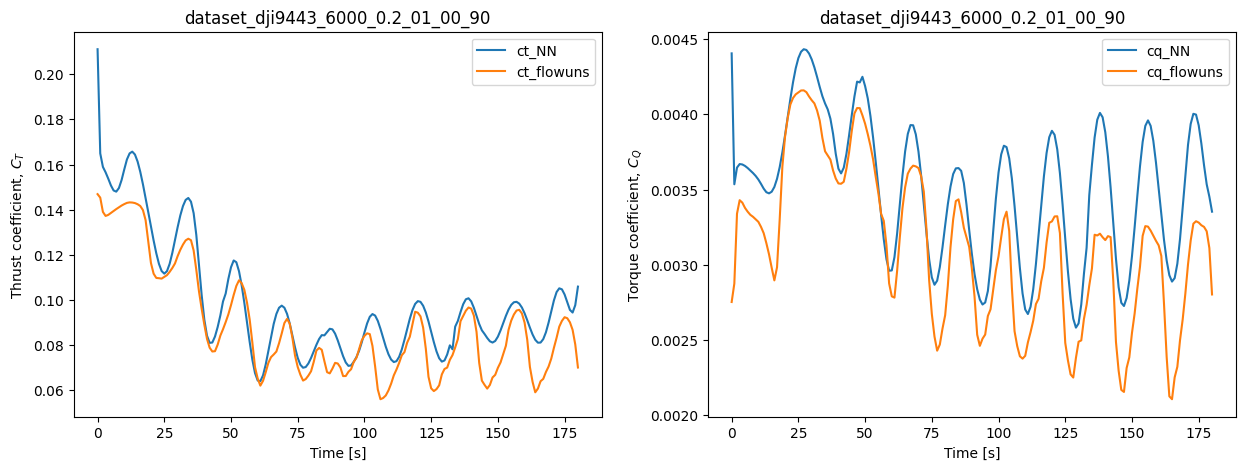

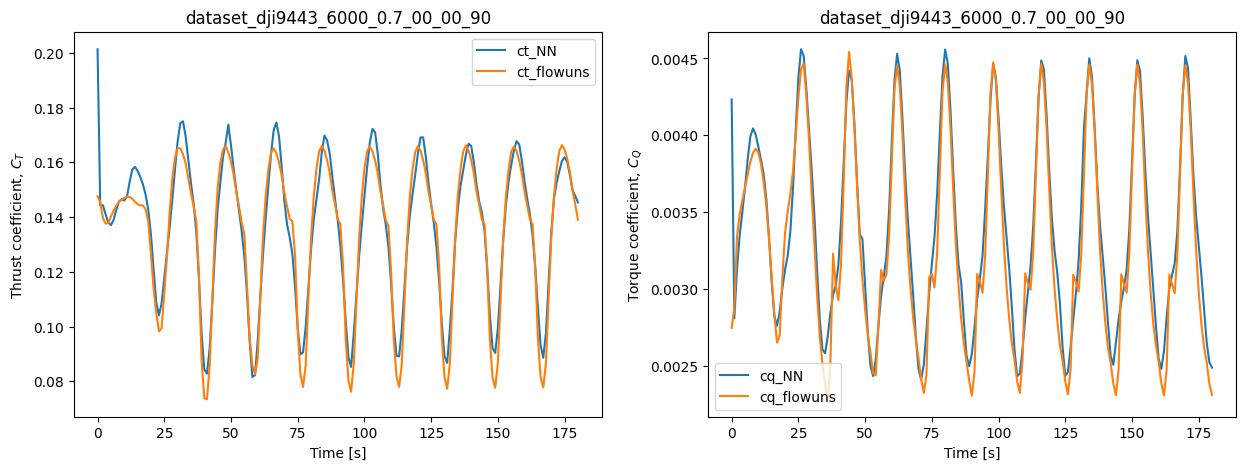

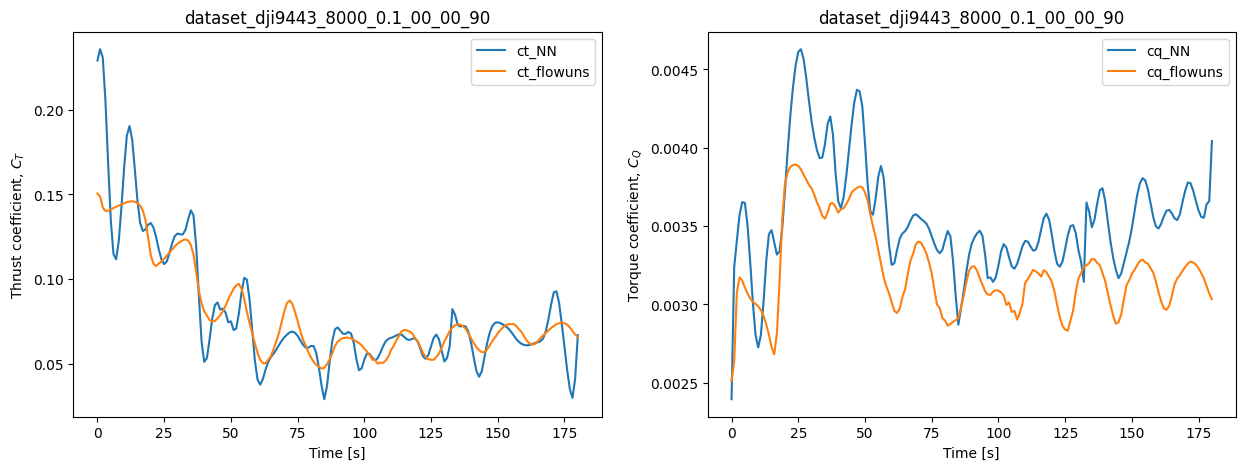

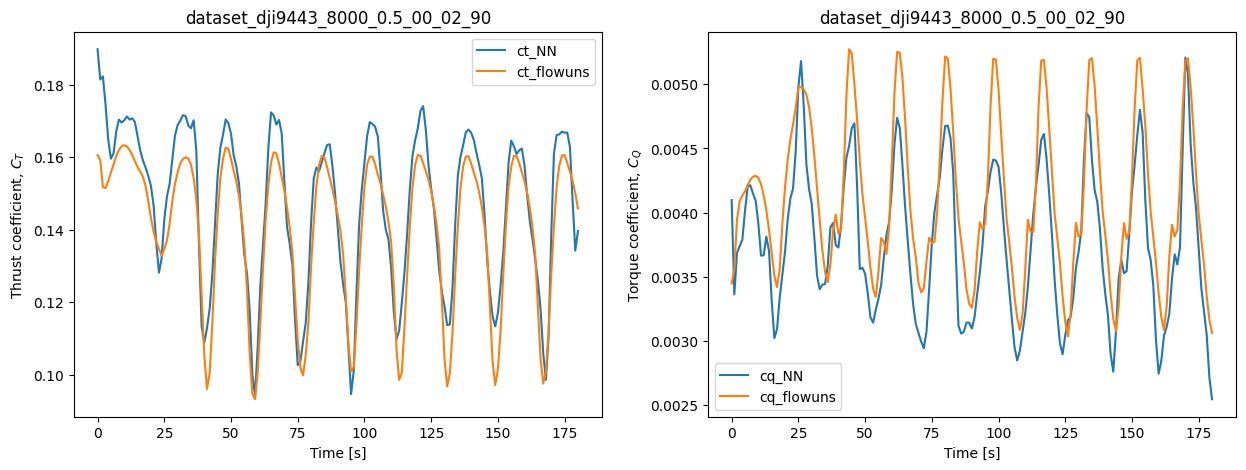

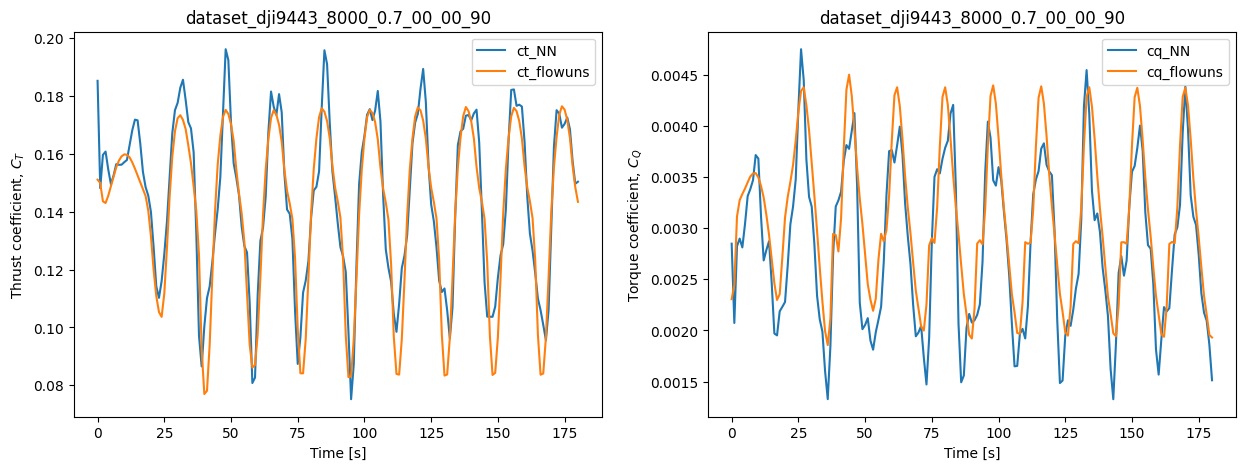

In [109]:
# Root directory where simulation subdirectories are stored
root_dir_test_base = "./FLOWUnsteady_simulations/test_data/"

for simulation_case in os.listdir(root_dir_test_base):
    # Root directory where simulation subdirectories are stored
    root_dir_test_sim = root_dir_test_base+simulation_case

    # Parameters to define
    # alpha_test = 0.0   # Angle of attack
    # J_test = [0.65]       # Advance ratio
    # theta_test = 0.0  # Pitch
    # yaw_test = 0.0     # Yaw
    # tilt_test = 0.0    # Tilt

   

    # Create the dataset with a subdirectory condition
    # dataset_test = PropellerDataset(root_dir_test_sim, alpha_test, J_test, theta_test, yaw_test, tilt_test, subdir_condition=subdir_condition)
    dataset_test = PropellerDataset(root_dir_test_sim, subdir_condition=subdir_condition)
    inputs_test, outputs_test = dataset_test[0:]

    # Assuming your input tensor is named `input_tensor`
    input_tensor_test = inputs_test.squeeze(1)  # Remove the singleton dimension at index 1
    print("Input shape:", input_tensor_test.shape)  # Should print: torch.Size([6, 145, 7])

    output_tensor_test = outputs_test.squeeze(1)
    print("Output shape:",output_tensor_test.shape)

    inputs_test_reshaped = input_tensor_test.reshape(-1, input_size)

    test_inputs_normalized = input_scaler.transform(inputs_test_reshaped.reshape(-1, input_size)).reshape(input_tensor_test.shape)

    test_inputs_tensor = torch.tensor(test_inputs_normalized, dtype=torch.float32).to(device)

    # Make predictions using the trained model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predicted_outputs = model(test_inputs_tensor)


    # Convert the predictions back to numpy and inverse scale the outputs
    predicted_outputs = predicted_outputs.cpu().detach().numpy()  # Convert tensor to numpy array
    predicted_outputs_original_scale = output_scaler.inverse_transform(predicted_outputs.reshape(-1, output_size))

    # Reshape the predictions to match the original sequence structure if needed
    predicted_outputs_original_scale = predicted_outputs_original_scale.reshape(input_tensor_test.shape[0], input_tensor_test.shape[1], output_size)
    predicted_outputs_original_scale = predicted_outputs_original_scale[0]

    # print(predicted_outputs_original_scale.shape)

    # Model predicted values
    # ct_test_NN = predicted_outputs_original_scale[:,0]
    # cq_test_NN = predicted_outputs_original_scale[:,1]

    fft_ct_nn_real = predicted_outputs_original_scale[:,0]
    fft_cq_nn_real = predicted_outputs_original_scale[:,2]
    
    fft_ct_nn_imag = predicted_outputs_original_scale[:,1]
    fft_cq_nn_imag = predicted_outputs_original_scale[:,3]

    # Load timesteps, CT and CQ from FLOWUnsteady simualtions
    time_steps = dataset_test.get_variable('time')

    ct_test_flowuns = dataset_test.get_variable('CT')
    cq_test_flowuns = dataset_test.get_variable('CQ')

    fft_ct_fu_real, fft_ct_fu_imag = dataset_test.get_variable('fft_ct')
    fft_cq_fu_real, fft_cq_fu_imag = dataset_test.get_variable('fft_cq')

    complex_ct_nn = fft_ct_nn_real +1j * fft_ct_nn_imag
    ct_test_NN = ifft(complex_ct_nn)

    complex_cq_nn = fft_cq_nn_real +1j * fft_cq_nn_imag
    cq_test_NN = ifft(complex_cq_nn)

    # complex_fft_coeff = real_part_nn + 1j * imaginary_part_actual

    

    # Plot the results

    # plt.figure()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    # plt.plot(time_steps[0], ct_test_NN, label = 'ct_NN')
    # plt.plot(time_steps[0], (ct_test_flowuns[0]), label = 'ct_flowuns')
    plt.plot(ct_test_NN, label = 'ct_NN')
    plt.plot((ct_test_flowuns[0]), label = 'ct_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Thrust coefficient, $C_T$')
    plt.title(simulation_case)
    plt.legend()

    # plt.figure()
    plt.subplot(1, 2, 2)
    # plt.plot(time_steps[0], cq_test_NN, label = 'cq_NN')
    # plt.plot(time_steps[0], cq_test_flowuns[0], label = 'cq_flowuns')
    plt.plot(cq_test_NN, label = 'cq_NN')
    plt.plot(cq_test_flowuns[0], label = 'cq_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Torque coefficient, $C_Q$')
    plt.title(simulation_case)
    plt.legend()

    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(fft_ct_nn_real, label = 'fft_ct_NN real')
    # plt.plot(fft_ct_fu_real[0], label = 'fft_ct_flowuns real')
    # # plt.xlabel('Time [s]')
    # # plt.ylabel('Thrust coefficient, $C_T$')
    # plt.title(simulation_case)
    # plt.legend()

    # # plt.figure()
    # plt.subplot(1, 2, 2)
    # plt.plot(fft_cq_nn_real, label = 'fft_cq_NN real')
    # plt.plot(fft_cq_fu_real[0], label = 'fft_cq_flowuns real')
    # # plt.xlabel('Time [s]')
    # # plt.ylabel('Torque coefficient, $C_Q$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(fft_ct_nn_imag, label = 'fft_ct_NN im')
    # plt.plot(fft_ct_fu_imag[0], label = 'fft_ct_FU im')
    # # plt.plot(time_steps[0], (ct_test_flowuns[0]), label = 'ct_flowuns')
    # # plt.xlabel('Time [s]')
    # # plt.ylabel('Thrust coefficient, $C_T$')
    # plt.title(simulation_case)
    # plt.legend()

    # # plt.figure()
    # plt.subplot(1, 2, 2)
    # plt.plot(fft_cq_nn_imag, label = 'fft_cq_NN im')
    # plt.plot(fft_cq_fu_imag[0], label = 'fft_cq_FU im')
    # # plt.plot(time_steps[0], cq_test_flowuns[0], label = 'cq_flowuns')
    # # plt.xlabel('Time [s]')
    # # plt.ylabel('Torque coefficient, $C_Q$')
    # plt.title(simulation_case)
    # plt.legend()

Actual:  (181,)
NN:  (181,)


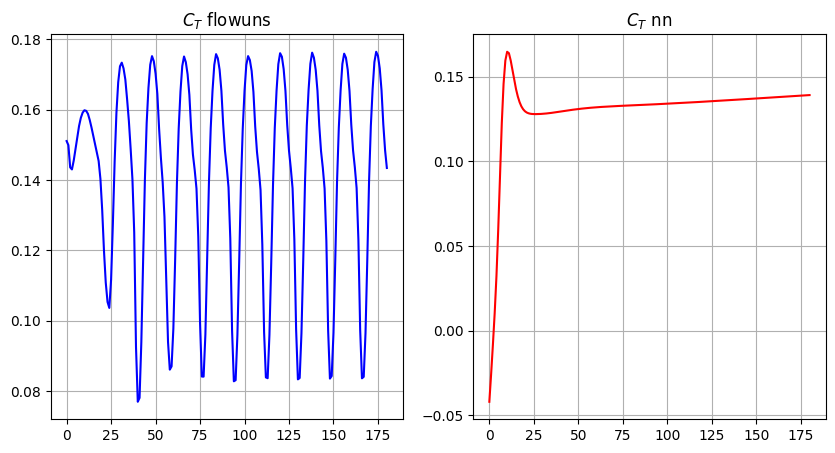

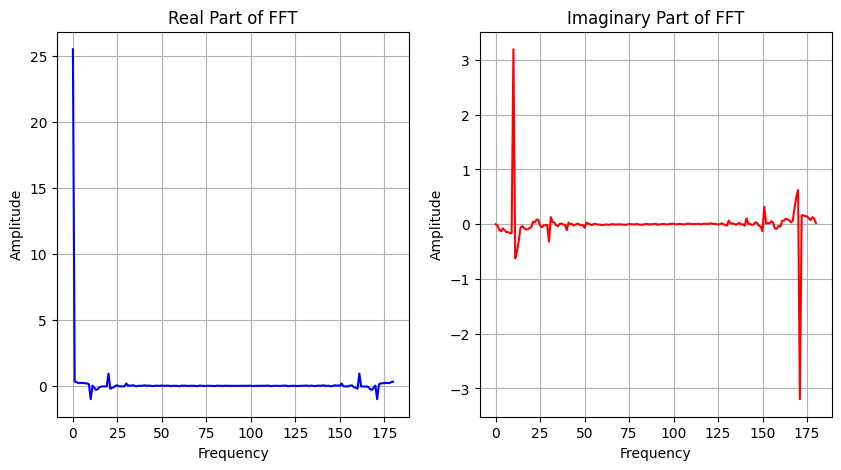

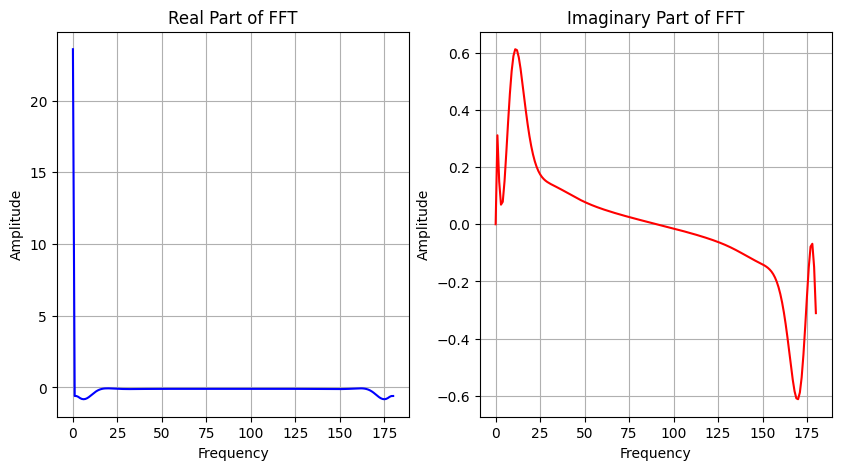

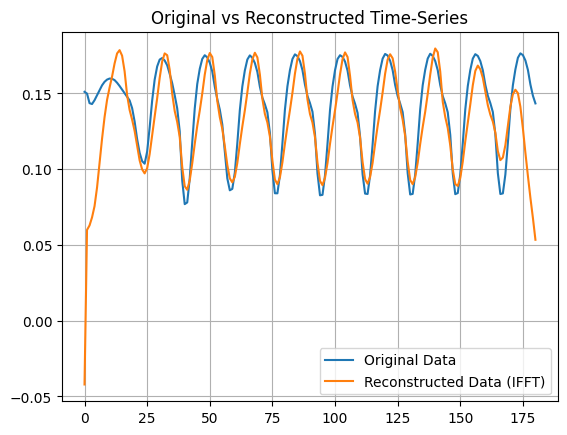

In [35]:


from scipy.fftpack import fft, ifft

# print(len(time_steps[0]))

# Sample time-series data (thrust, torque)

ct_actual = ct_test_flowuns
ct_nn = ct_test_NN

time_series_data_actual = np.array(ct_test_flowuns[0])
time_series_data_nn = np.array(ct_test_NN)

print("Actual: ", time_series_data_actual.shape)
print("NN: ", time_series_data_nn.shape)

# 1. Apply FFT to extract periodic component
fft_coeff_actual = fft(time_series_data_actual)
fft_coeff_nn = fft(time_series_data_nn)

# Pass the real and imaginary parts (frequency components) to LSTM
real_part_actual = np.real(fft_coeff_actual)
imaginary_part_actual = np.imag(fft_coeff_actual)

real_part_nn = np.real(fft_coeff_nn)
imaginary_part_nn = np.imag(fft_coeff_nn)


complex_fft_coeff = real_part_nn + 1j * imaginary_part_actual

# Step 4: Perform inverse FFT to recover the original time-series signal
reconstructed_time_series = ifft(complex_fft_coeff)

# Step 5: (Optional) Extract the real part of the reconstructed signal (since IFFT might result in a small imaginary part due to precision errors)
reconstructed_time_series_real = np.real(reconstructed_time_series)


# Convert tensors to NumPy arrays for plotting
# real_part_np = real_part.numpy()
# imaginary_part_np = imaginary_part.numpy()

# Plotting the real part
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # First subplot for real part
plt.plot(ct_test_flowuns[0], color='blue', label='Real Part')
plt.title('$C_T$ flowuns')
# plt.xlabel('Frequency')
# plt.ylabel('Amplitude')
plt.grid(True)

# Plotting the imaginary part
plt.subplot(1, 2, 2)  # Second subplot for imaginary part
plt.plot(ct_test_NN, color='red', label='Imaginary Part')
plt.title('$C_T$ nn')
# plt.xlabel('Frequency')
# plt.ylabel('Amplitude')
plt.grid(True)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # First subplot for real part
plt.plot(real_part_actual, color='blue', label='Real Part')
plt.title('Real Part of FFT')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)

# Plotting the imaginary part
plt.subplot(1, 2, 2)  # Second subplot for imaginary part
plt.plot(imaginary_part_actual, color='red', label='Imaginary Part')
plt.title('Imaginary Part of FFT')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # First subplot for real part
plt.plot(real_part_nn, color='blue', label='Real Part')
plt.title('Real Part of FFT')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)

# Plotting the imaginary part
plt.subplot(1, 2, 2)  # Second subplot for imaginary part
plt.plot(imaginary_part_nn, color='red', label='Imaginary Part')
plt.title('Imaginary Part of FFT')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)

# Show the plots
# plt.tight_layout()
plt.figure()
plt.plot(time_series_data_actual, label='Original Data')
plt.plot(reconstructed_time_series_real, label='Reconstructed Data (IFFT)')
plt.legend()
plt.title('Original vs Reconstructed Time-Series')
plt.grid(True)
# plt.show()

plt.show()

# Now pass these frequency components along with the original data to the LSTM
# Example: inputs = [time_series_data, real_part, imaginary_part]